# import

In [1]:
import keras
import numpy as np
import tensorflow as tf
import sklearn
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import os


In [8]:
Base_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
IMAGE_SIZE = 224,224
EPOCH = 50
BATCH_SIZE = 16
N_CHANNEL = 3
N_CLASS= 3
INPUT_SHAPE = (IMAGE_SIZE[0],IMAGE_SIZE[1], N_CHANNEL)

# Preproccesing

In [3]:
# Function to retrieve image paths and their corresponding labels from a directory
def get_data_and_label(directory):
    data_paths = []
    data_labels = []

    label_dict = {label: index for index, label in enumerate(os.listdir(directory))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)

        for file in os.listdir(label_dir):
            if file and file.endswith(('mask.png', 'mask_1.png', 'mask_2.png')):
                data_paths.append(os.path.join(label_dir, file))
                data_labels.append(index)

    data_paths, data_labels = sklearn.utils.shuffle(data_paths, data_labels, random_state=42)

    return data_paths, data_labels
    

# Split into train, test sets
def split_train_test(data_paths, data_labels):
   
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        data_paths, data_labels, test_size=0.10, random_state=42, stratify=data_labels
    )
    return train_paths, test_paths, train_labels, test_labels


# Function for preprocessing and creating TensorFlow dataset
def create_dataset_with_preprocessing(paths, labels, image_size, n_channel, batch_size, n_classes):
    def parse_function(filename, label):
        image_string = tf.io.read_file(filename)
        image_decoded = tf.io.decode_png(image_string, channels=n_channel)
        image_resized = tf.image.resize(image_decoded, image_size)
        return image_resized, label

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [4]:
data_paths, data_labels = get_data_and_label(Base_path)

train_paths, test_paths, train_labels, test_labels = split_train_test(data_paths, data_labels)

print(f"Training set size: {len(train_paths)}")
print(f"Test set size: {len(test_paths)}")

train_ds  = create_dataset_with_preprocessing(train_paths, train_labels, 
                                              image_size = IMAGE_SIZE,
                                              n_channel= N_CHANNEL,
                                              batch_size = BATCH_SIZE,
                                              n_classes = N_CLASS)
test_ds = create_dataset_with_preprocessing(test_paths, test_labels,
                                               image_size = IMAGE_SIZE,
                                               n_channel= N_CHANNEL,
                                               batch_size = BATCH_SIZE,
                                               n_classes = N_CLASS )

print(f'\nTraining Dataset {train_ds}')
print(f'\nTest Dataset {test_ds}')

# Class mapping
class_mapping ={label: index for index, label in enumerate(os.listdir(Base_path))}
inv_class_mapping = {index : label for label, index in class_mapping.items()}
class_names = list(class_mapping.keys())

print(f'\nClass Mapping {class_mapping}')
print(f'\nInverse Class Mapping {inv_class_mapping}')
print(f'\nClass Names {class_names}')

Training set size: 718
Test set size: 80

Training Dataset <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Test Dataset <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Class Mapping {'benign': 0, 'normal': 1, 'malignant': 2}

Inverse Class Mapping {0: 'benign', 1: 'normal', 2: 'malignant'}

Class Names ['benign', 'normal', 'malignant']


# Training Setup

In [5]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2,fill_mode='constant'),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomZoom(height_factor=0.01, width_factor=0.05),
    tf.keras.layers.RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant')
    ])

# Training augmentation and nornalization
def train_preprocess(image, label):
    image = data_augmentation(image)/255.0
    return image, tf.one_hot(label,depth= N_CLASS)

# For test dataset only appying normalization
def test_preprocess(image, label):
    image = image/255.0
    return image, tf.one_hot(label,depth= N_CLASS)

train_ds_processed = train_ds.map(train_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_processed = test_ds.map(test_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Defning and Training the Model

In [6]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels), 
    y=train_labels  
)

# Convert to dictionary format for Keras
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.5866013071895425, 1: 1.9944444444444445, 2: 1.2596491228070175}


In [9]:
inp = keras.layers.Input(shape=INPUT_SHAPE)

model = Sequential()

pretrained_model= keras.applications.ResNet50(include_top=False,
                   input_shape=(INPUT_SHAPE),
                   pooling='max',classes= N_CLASS,
                   weights='imagenet')


model.add(pretrained_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())  
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

#pretrained_model.trainable=False
for layer in pretrained_model.layers:
    layer.trainable = False
# Unfreeze the last few layers for fine-tuning(I achieved much better results adding this step)
for layer in pretrained_model.layers[-8:]:
    layer.trainable = True
    

optimizer= Adam(learning_rate=0.0005) 
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',  
                metrics=['accuracy'])
print(model.summary())
 

from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = 'best_model_weights.weights.h5'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max', 
                             save_weights_only=True)
#Fit the model
history = model.fit(   train_ds_processed ,
                         batch_size = BATCH_SIZE ,
                         verbose = 1,
                         epochs = EPOCH,    
                         validation_data= test_ds_processed,
                         shuffle = True,
                         class_weight=class_weights,
                         callbacks=[checkpoint]
                     )
                                        
model.load_weights(checkpoint_path)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,640,387 (94.00 MB)

 Trainable params: 4,467,203 (17.04 MB)

 Non-trainable params: 20,173,184 (76.95 MB)

None
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4411 - loss: 1.3690
Epoch 1: val_accuracy improved from -inf to 0.68750, saving model to best_model_weights.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - accuracy: 0.4423 - loss: 1.3647 - val_accuracy: 0.6875 - val_loss: 3.0775
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5313 - loss: 1.1076
Epoch 2: val_accuracy did not improve from 0.68750
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.5314 - loss: 1.1064 - val_accuracy: 0.5875 - val_loss: 1.2040
Epoch 3/50
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5248 - loss: 0.9026
Epoch 3: val_accuracy improved from 0.68750 to 0.76250, saving model to best_model_weights.weights.h5
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.5268 - loss: 0.9007 - val_accuracy: 0.7625 - val_loss: 0.5016
Epoch 4/50
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6443 - loss: 0.6899
Epoch 4: val_accuracy did not improve from 0.76250

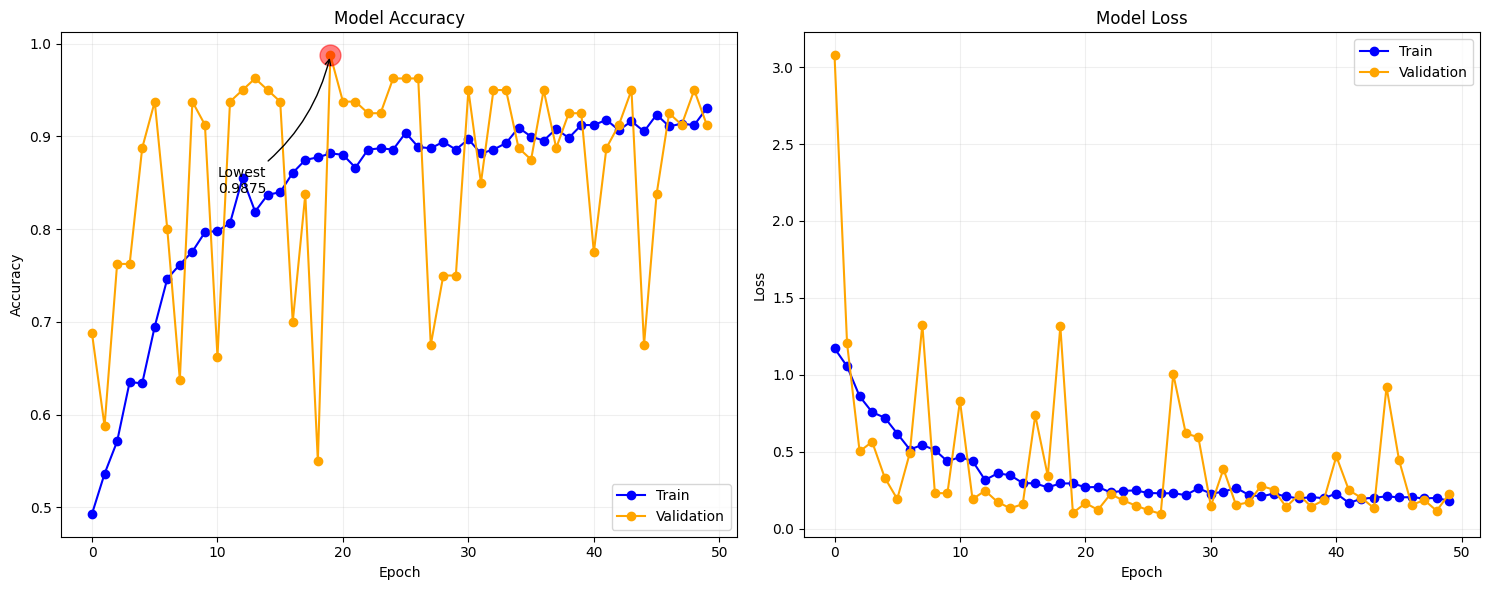

In [10]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
ax[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='lower right')
ax[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
ax[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
ax[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper right')
ax[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
ax[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
ax[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),

xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [11]:
true_labels =[]
predict_labels =[]

for image, label in test_ds_processed.unbatch():
    true_labels.append(np.argmax(label.numpy()))
    prediction = model.predict(tf.expand_dims(image,0),verbose= False)
    predict_labels.append(np.argmax(prediction))

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def evaluate_model_performance(true_labels, predict_labels):
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predict_labels)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, square=True)
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)

    # Adding class names to the axis
    plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, ha='center', fontsize=12)
    plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, va='center', fontsize=12)

    plt.show()

    # Classification Metrics
    print("\nClassification Metrics:\n")

    # Accuracy
    accuracy = accuracy_score(true_labels, predict_labels)
    print(f"Accuracy: {accuracy:.4f}\n")

    # Detailed Classification Report
    print("Detailed Classification Report:\n")
    print(classification_report(true_labels, predict_labels, target_names=class_names))



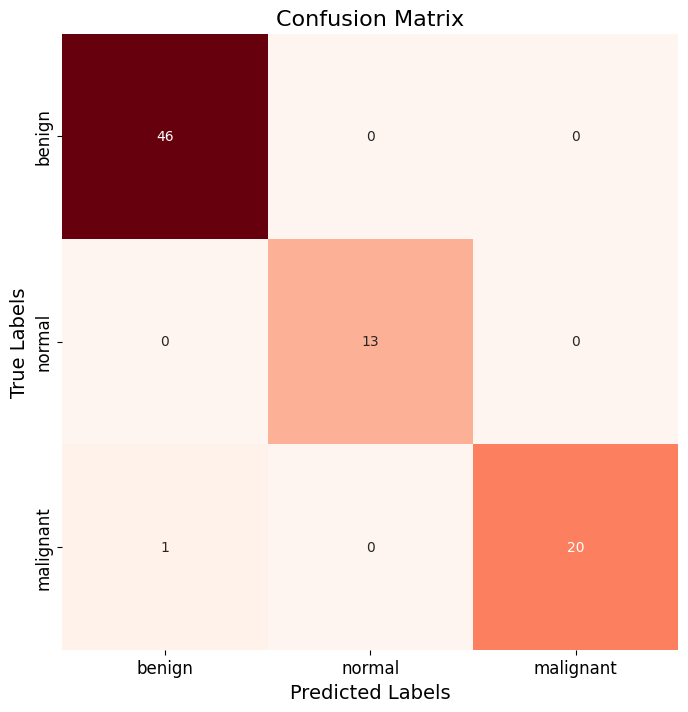


Classification Metrics:

Accuracy: 0.9875

Detailed Classification Report:

              precision    recall  f1-score   support

      benign       0.98      1.00      0.99        46
      normal       1.00      1.00      1.00        13
   malignant       1.00      0.95      0.98        21

    accuracy                           0.99        80
   macro avg       0.99      0.98      0.99        80
weighted avg       0.99      0.99      0.99        80



In [14]:
evaluate_model_performance(true_labels, predict_labels, )